In [1]:
import netCDF4 as nc
import scipy 
import os
import re
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import dask
from xmhw.xmhw import threshold, detect
from datetime import date
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
import hashlib
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
import glob
import math
import seaborn as sns
import matplotlib.lines as mlines

In [2]:
from glob import glob
from scipy.spatial import cKDTree
from timeit import default_timer as timer
def find_nearest_ocean_cell(lat, lon, dataset):
    """
    Improved method to find the nearest ocean cell for a given latitude and longitude using a KDTree for spatial search.
    
    Args:
    - lat (float): Latitude of the land coordinate.
    - lon (float): Longitude of the land coordinate.
    - dataset (xarray.Dataset): The dataset containing SST data.
    
    Returns:
    - (float, float): Latitude and longitude of the nearest ocean cell with valid SST data,
                      or (None, None) if no valid ocean cell is found.
    """
    # Ensure longitude is in the same format as the dataset
    if lon < 0:
        lon += 360
    
    # Flatten the lat/lon coordinates and create a KDTree for spatial search
    lats = dataset['lat'].values
    lons = dataset['lon'].values
    lon_grid, lat_grid = np.meshgrid(lons, lats)
    valid_mask = np.isfinite(dataset['sst'].isel(time=0, zlev=0).values.ravel())  # Check first time and level
    valid_points = np.vstack([lat_grid.ravel()[valid_mask], lon_grid.ravel()[valid_mask]]).T
    tree = cKDTree(valid_points)

    # Find the nearest valid (ocean) cell
    distance, location = tree.query([lat, lon], k=1)  # k=1 for the nearest neighbor
    nearest_lat, nearest_lon = valid_points[location]

    return nearest_lat, nearest_lon

#### import comparable kelp and urchin sites

In [ ]:
df_concat_mhw = pd.read_csv('all_ukmhw_with_level.csv')  #  all_urchin_kelp_mhw
df_concat_mhw = df_concat_mhw[df_concat_mhw.longitude > 140].reset_index(drop = True)

In [6]:
locations = ['Jervis Bay', 'Batemans', 'Kent Group','Bicheno', 'Maria Island'] #, 'Tinderbox'

#### urchin differences between different periods -- violin/box plot

In [ ]:
def custom_bin_edges(years, target_bins=4, min_bin_size=3):
    min_year, max_year = min(years), max(years)
    total_years = max_year - min_year
    
    # Adjust bin count based on data range, ensuring at least 4-5 bins and min bin size of 3 years
    num_bins = max(4, min(5, total_years // min_bin_size))  # Keep between 4-5 bins
    bin_edges = np.linspace(min_year, max_year + 1, num_bins + 1)  # Ensure consistent bin number
    
    return bin_edges

In [7]:
df_bins = []
for location in locations:
    df_concat_mhw_i = df_concat_mhw.loc[df_concat_mhw["location"] == location].copy()
    
    bin_edges = custom_bin_edges(df_concat_mhw_i["survey_year"].unique())
    bin_labels = [f"{int(start)}-{int(end-1)}" for start, end in zip(bin_edges[:-1], bin_edges[1:])]
    
    df_concat_mhw_i["period"] = pd.cut(df_concat_mhw_i["survey_year"], bins=bin_edges, labels=bin_labels, right=False)
    df_bins.append(df_concat_mhw_i)

# Combine all locations back into one dataframe
df_box = pd.concat(df_bins).reset_index(drop=True)
df_box

,location,survey_year,site_name,taxon,latitude,longitude,survey_id,survey_mean,number,summer_temp,summer_dhd50,summer_inten,max_inten_prolonged,nmhw,duration,period
0,Jervis Bay,1996,Bowen Island NW,Ecklonia radiata,-35.11272,150.76720,8.123103e+08,9.8,4.930000,21.323223,2.336214,0.817026,False,0,0.0,1996-2000
1,Jervis Bay,1996,Bowens Island SW,Ecklonia radiata,-35.12113,150.76416,8.123103e+08,0.0,2.750000,21.323223,2.336214,0.817026,False,0,0.0,1996-2000
2,Jervis Bay,1996,Bristol Pt,Ecklonia radiata,-35.13438,150.72665,8.123105e+08,40.1,1.013333,21.323223,2.336214,0.817026,False,0,0.0,1996-2000
3,Jervis Bay,1996,Captains Pt,Ecklonia radiata,-35.12097,150.70789,8.123092e+08,60.5,0.710000,21.323223,2.336214,0.817026,False,0,0.0,1996-2000
4,Jervis Bay,1996,Dart Point East (Grouper Coast South),Ecklonia radiata,-35.07469,150.77344,8.123100e+08,65.0,0.285000,21.323223,2.336214,0.817026,False,0,0.0,1996-2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1260,Maria Island,2023,Painted Cliffs South (Four Mile Reef),Ecklonia radiata,-42.60250,148.04628,9.234028e+08,30.5,0.045000,17.138477,34.730377,1.290152,False,0,0.0,2017-2023
1261,Maria Island,2023,Point Holme Lookout,Ecklonia radiata,-42.55305,147.94814,9.234028e+08,4.7,0.000000,17.138477,34.730377,1.290152,False,0,0.0,2017-2023
1262,Maria Island,2023,Point Leseuer,Ecklonia radiata,-42.66082,148.00697,9.234028e+08,14.2,0.000000,17.138477,34.730377,1.290152,False,0,0.0,2017-2023
1263,Maria Island,2023,Return Point,Ecklonia radiata,-42.62899,148.02431,9.234028e+08,43.7,0.000000,17.138477,34.730377,1.290152,False,0,0.0,2017-2023


/jobfs/142010585.gadi-pbs/ipykernel_3165287/122264058.py:90: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.


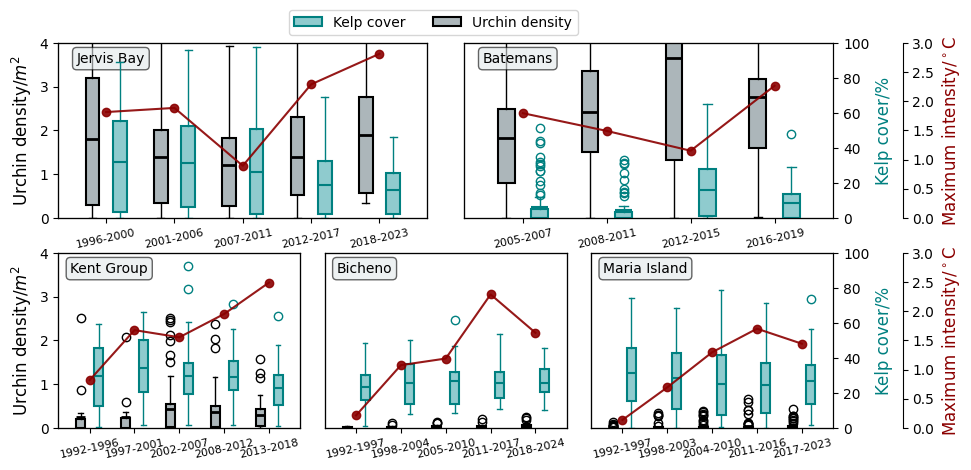

In [11]:
df_meansst = df_box.groupby(['location', 'period']).mean(numeric_only = True).reset_index()


# fig, axs = plt.subplots(2, 5, figsize=(15, 3), sharex=True) 
# Flatten axs for easier indexing
# axs = axs.flatten()
fig  = plt.figure(figsize=(10, 5), num=1, clear=True)
axTL = fig.add_subplot(2, 2, 1)
axTR = fig.add_subplot(2, 2, 2)
axB1 = fig.add_subplot(2, 3, 4)
axB2 = fig.add_subplot(2, 3, 5)
axB3 = fig.add_subplot(2, 3, 6)
axs = [axTL, axTR, axB1, axB2, axB3]
handles = []
labels = []
for i, location in enumerate(locations):
    dfi = df_[df_box.location == location]
    dfi_sst = df_meansst[df_meansst.location == location]
    all_period_sorted = np.sort(dfi['period'].unique())
    
    data_box1 = [dfi[dfi['period'] == period]['number'] for period in all_period_sorted]
    data_box2 = [dfi[dfi['period'] == period]['survey_mean'] for period in all_period_sorted]
    
    ax = axs[i]  # Start plotting from axs[1] (i.e., axs[0,1])
    
    box1 = ax.boxplot(data_box1, showmeans=True, meanline=True, medianprops=dict(color='none'), widths=0.2, 
                positions =[i - 0.2 for i in range(0, len(dfi['period'].unique()))], patch_artist=True, 
                boxprops=dict(facecolor='#ACB6BA', color='black', linewidth = 1.5), 
                meanprops = dict(linestyle='-', color="black",linewidth=2),
                whiskerprops=dict(color='k'))
    ax.set_ylim(0, 4)
    ax.set_yticks(np.arange(0, 5, 1))

    # Create secondary y-axis for Urchin
    ax2 = ax.twinx()

    # Create the second boxplot (right plot)
    box2 = ax2.boxplot(data_box2, showmeans=True, meanline=True, medianprops=dict(color='none'), widths=0.2, 
                        positions =[i + 0.2 for i in range(0, len(dfi['period'].unique()))], patch_artist=True, 
                        boxprops=dict(facecolor='#8FCBCE', color='teal', linewidth = 1.5), 
                        meanprops = dict(linestyle='-', color="teal",linewidth=1.5),
                        whiskerprops=dict(color='teal'), #linestyle='--',
                        capprops = dict(color = 'teal'),
                        flierprops = dict(markeredgecolor='teal'))
    ax2.set_ylim(0, 100)
        
    ax3 = ax.twinx()
    # ax.set_zorder(3)
    # ax2.set_zorder(2)
    # ax3.set_zorder(1)  # Lowest z-order for ax3
    # ax.patch.set_visible(False)  
    x_axis = np.arange(len(dfi['period'].unique())) 
    ax3.plot(x_axis, dfi_sst['summer_inten'], 'o-', color='darkred', linewidth = 1.5, alpha = 0.9)
    ax3.set_ylim(0,3) #15, 24
    
    ax.set_xticks(range(0, len(dfi['period'].unique())), all_period_sorted, rotation=12, fontsize=8)
    # ax.set_xticklabels(df_long.period.unique(), rotation = 20, fontsize=6)
    # ax.set_ylim(0, 50)
    if i in [0,2]:
        ax.set_ylabel(r'Urchin density/$m^2$', color='k', fontsize=12)
        if i == 0:
            handles.append(box2['boxes'][0])  # Add the first box as the handle
            labels.append('Kelp cover')
            handles.append(box1['boxes'][0])  # Add the first box as the handle
            labels.append('Urchin density')
    else: 
        ax.set_yticks([])  # Hides the y-axis ticks
        ax.set_yticklabels([]) 

    if i in [1, 4]:
        ax2.set_ylabel('Kelp cover/%', color='teal', fontsize=12)
        ax3.set_ylabel('Maximum intensity/$^\circ$C', color='darkred', fontsize=12)
        ax3.spines['right'].set_position(('outward', 50))  # Offset the third axis
    else:
        ax2.set_yticks([])  # Hides the y-axis ticks
        ax2.set_yticklabels([]) 
        ax3.set_yticks([])  # Hides the y-axis ticks
        ax3.set_yticklabels([]) 
        ax3.yaxis.set_visible(False)  # Completely hides the y-axis
    
    # Titles and labels
    ax.set_title('', fontsize=14)
    props = dict(boxstyle='round', facecolor='#E2E8EA', alpha=0.6)
    ax.text(0.05, 0.95, f'{location}', transform=ax.transAxes, fontsize=10, va='top', ha='left', bbox=props)
fig.legend(handles=handles, labels=labels, loc='upper center', bbox_to_anchor=(0.5, 0.96), ncol=2, fontsize=10)

plt.tight_layout()  # Shrink plot area to fit legend
plt.subplots_adjust(wspace=0.1) 